In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import torch 
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import glymur

In [2]:
class_min_dict = {"amphibole":(52,82,52),
              "apophyllite":(0,255,0),
              "aspectral":(209,209,209),
              "biotite":(128,0,0),
              "carbonate":(0,255,255),
              "carbonate-actinolite":(44,109,0),
              "chlorite":(0,192,0),
              "clinochlore":(45,95,45),
              "dickite":(148,138,84),
              "epidote":(188,255,55),
              "iron carbonate":(185,255,255),
              "iron oxide":(255,154,0),
              "gypsum":(213,87,171),
              "kaolinite":(191,183,143),
              "montmorillonite":(175,175,255),
                "NA":(0,0,0),
              "nontronite":(105,105,255),
              "phlogopite":(88, 0, 0),
              "prehnite":(70, 70, 220),
              "sericite":(58,102,156),
              "silica":(166,166,166),
              "tourmaline":(255,0,0),
                "UNK1":(83, 141, 213),
                "UNK2":(155, 187, 89),
                "UNK3":(0, 108, 105),
              "vermiculite":(95, 100, 200)
             }

class_RGB_dict = {v: k for k, v in class_min_dict.items()}

In [269]:
path = '../img-rgb-50u'
label_path = '../img-clm-phy'
img_list = [i for i in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, i))]
# print(img_list)

## Check for missing RGB values

In [7]:
# s = set()
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         s.add(tuple(img[i,j]))
        
# for i in s:
#     if i not in class_RGB_dict.keys():
#         print("{} Not found".format(i))

% of known image contents:  0.99995
% of known image contents:  0.99999375
% of known image contents:  0.99996875
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.9999125
% of known image contents:  0.99999375
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.99860625
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.99810625
% of known image contents:  1.0
% of known image contents:  0.99991875
% of known image contents:  1.0
% of known image contents:  0.9999875
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  1.0
% of known image contents:  0.99996875
% of known image contents:  0.99998125
% of known image contents:  0.99996875
% of known image contents:  0.99998125
% of known image contents:  0.9997375
% of known image contents:  1.0
% of known i

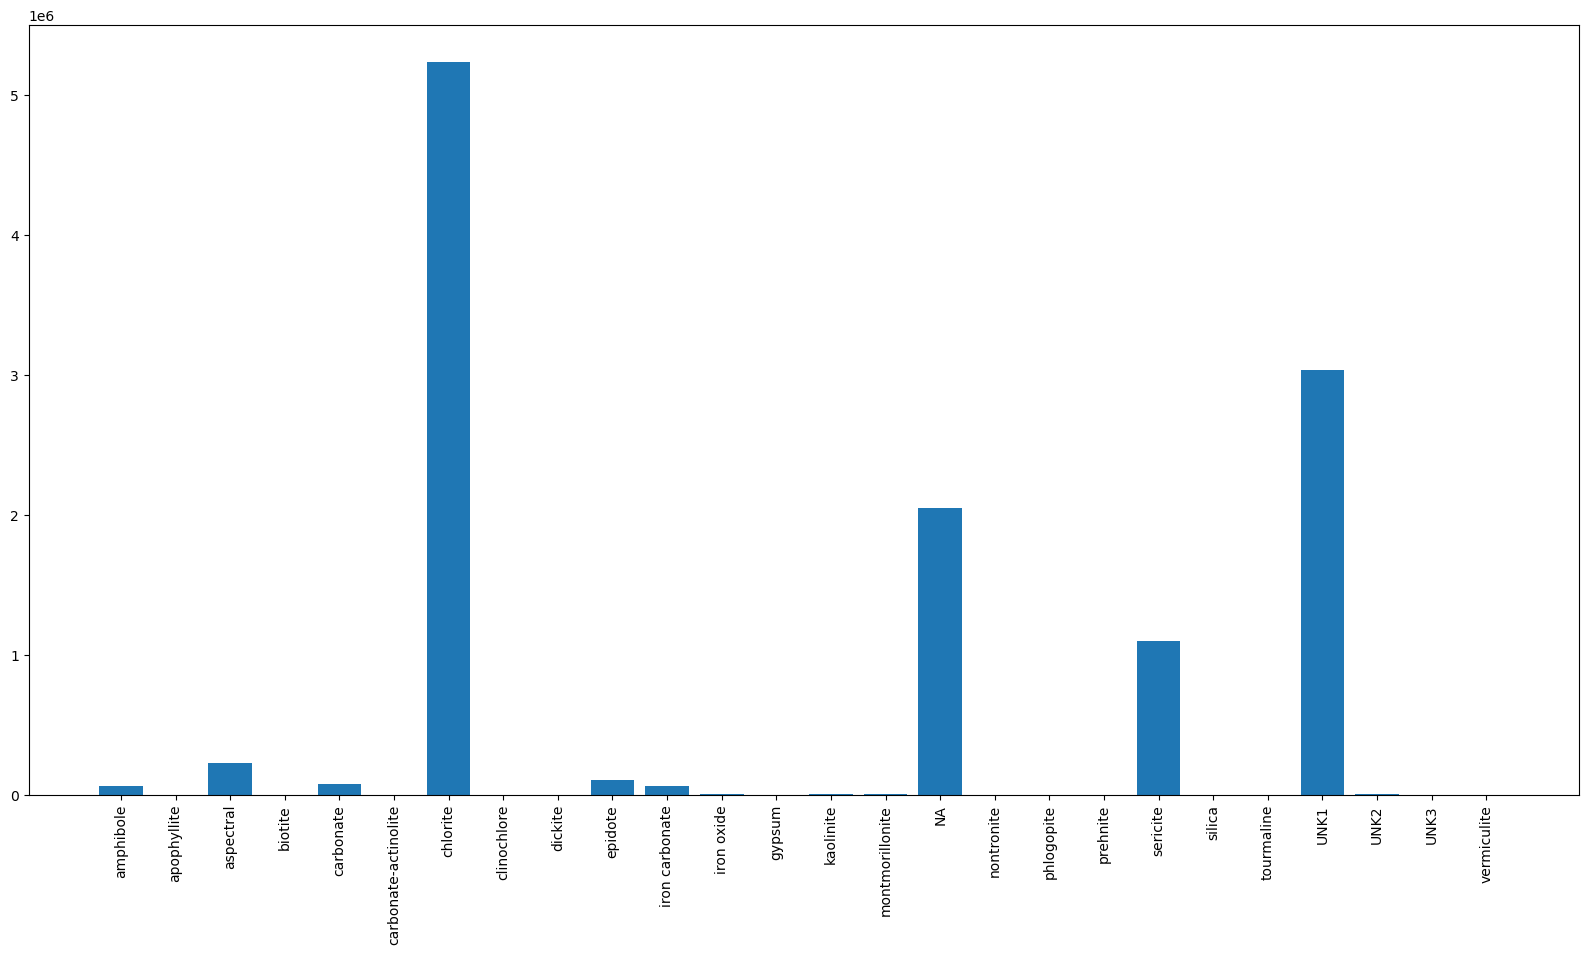

In [8]:
class_hist_dict = {}
for i in list(class_min_dict.keys()):
    class_hist_dict[i] = 0

for p in img_list:
    img = cv2.imread(os.path.join(label_path,p))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    total = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if tuple(img[i,j]) in class_RGB_dict:
                total +=1
                class_hist_dict[class_RGB_dict[tuple(img[i,j])]] =  class_hist_dict[class_RGB_dict[tuple(img[i,j])]] + 1
    print('% of known image contents: ', total/np.prod(img.shape[:2]))

plt.figure(figsize=(20,10));
plt.bar(list(class_hist_dict.keys()),list(class_hist_dict.values()));
plt.xticks(rotation='vertical');

## Create masking function

In [9]:
def create_mask(img,mineral,class_dict):
    #Input images should be channels x height x width
    mask = np.zeros(img.shape[1:])

    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            if tuple(img[:,i,j]) == class_dict[mineral]:
                mask[i,j] = 1
    return mask    

## Define U-NET architecture

In [10]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [11]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [12]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [13]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        #""" Encoder """
        self.e1 = encoder_block(3, 128) #3,64 original size
        self.e2 = encoder_block(128, 256) #64, 128
        self.e3 = encoder_block(256, 512) #128, 256
        self.e4 = encoder_block(512, 1024) #256, 512
        #""" Bottleneck """
        self.b = conv_block(1024, 2048) #512, 1024
        #""" Decoder """
        self.d1 = decoder_block(2048, 1024) #1024, 512
        self.d2 = decoder_block(1024, 512) #512, 256
        self.d3 = decoder_block(512, 256) #256, 128
        self.d4 = decoder_block(256, 128) #128, 64
        #""" Classifier """
        self.outputs = nn.Conv2d(128, 1, kernel_size=1, padding=0) #64,1
    def forward(self, inputs):
        #""" Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        #""" Bottleneck """
        b = self.b(p4)
        #""" Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        #""" Classifier """
        outputs = self.outputs(d4)
        outputs = torch.sigmoid(outputs)
        return outputs

In [183]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_unet()
model = model.to(device)
# model(torch.Tensor(np.transpose(np.expand_dims(img[:64,:64,:],axis=0),[0,3,1,2])))

## Create dataloader

In [270]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, mineral_type, class_dict, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_list = sorted([f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(img_dir,f))])
        self.label_list = sorted([f for f in os.listdir(self.label_dir) if os.path.isfile(os.path.join(label_dir,f))])
        self.transform = transform
        self.target_transform = target_transform
        self.mineral_type = mineral_type
        self.class_dict = class_dict

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        label_path = os.path.join(self.label_dir, self.label_list[idx])
            
        #Get header info
        j2k = glymur.Jp2k(img_path)
        j2k2 = glymur.Jp2k(label_path)
        
        rgb_tiepoint = j2k.box[3].data['ModelTiePoint'][3:6]
        cm_tiepoint = j2k2.box[3].data['ModelTiePoint'][3:6]
        rgb_res = j2k.box[3].data['ModelPixelScale'][0]
        cm_res = rgb_res*10
        
        #Read images
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        label = cv2.imread(label_path)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        
        #Resize and transpose
        rgb_box = (rgb_tiepoint,rgb_tiepoint+[img.shape[1]*rgb_res,-img.shape[0]*rgb_res,0])
        cm_box = (cm_tiepoint,cm_tiepoint+[label.shape[1]*cm_res,-label.shape[0]*cm_res,0])
        
        img = cv2.copyMakeBorder(img, -min(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                          max(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                          max(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                          -min(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                         cv2.BORDER_CONSTANT)
        label = cv2.copyMakeBorder(label, max(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                          -min(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                          -min(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                          max(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                         cv2.BORDER_CONSTANT)
            
        img = cv2.resize(img, (128,2048))
        label = cv2.resize(label, (128,2048))
    
        img = np.transpose(img,[2,1,0])
        label = np.transpose(label,[2,1,0])
        
        #Normalize images
        mean, std = np.mean(np.mean(img,axis=-1),axis=-1), np.std(np.std(img,axis=-1),axis=-1)
        mask = create_mask(label,self.mineral_type,self.class_dict)

        img = torch.Tensor(img)
        mask = torch.Tensor(mask)
        
        if self.transform:
            transform = transforms.Compose([transforms.Normalize(mean, std), self.transform])
            img = transform(img)
        else:
            transform = transforms.Normalize(mean, std)
            img = transform(img)
            pass
        if self.target_transform:
            mask = self.target_transform(label)
        return img, mask

In [13]:
# batch_size = 4 
# epochs = 50
# dataset = CustomImageDataset(path,label_path,'chlorite',class_min_dict)
# train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-8,8])
# train_dataloader = DataLoader(train_set, batch_size=batch_size)
# val_dataloader = DataLoader(val_set, batch_size=batch_size)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Patched data loader

In [326]:
def create_dataset(path, label_path, mineral, batch_size=1, seed = 42):
    generator1 = torch.Generator().manual_seed(seed)
    dataset = CustomImageDataset(path,label_path,mineral,class_min_dict)
    train_set, val_set = torch.utils.data.random_split(dataset, 
                            [int(0.9*len(dataset)), len(dataset)-int(0.9*len(dataset))],generator=generator1)
    train_dataloader = DataLoader(train_set, batch_size=batch_size)
    val_dataloader = DataLoader(val_set, batch_size=batch_size)
    return train_dataloader, val_dataloader


class CustomPatchDataset(Dataset):
    def __init__(self, img, label, mineral_type, class_dict, patch_size = (64,64)):
        self.img = img
        self.label = label
        self.mineral_type = mineral_type
        self.class_dict = class_dict
        self.patch_size = patch_size
        self.patches_per_img = (2048//self.patch_size[0])*(128//self.patch_size[1]) # Assume all images are resized to 2048, 128

    def __len__(self):
        return self.patches_per_img

    def __getitem__(self, idx):

        #Create patches here and choose patch
        patchy = (idx)//(128//self.patch_size[1]) # for patch size 32 this ranges from 0-63
        patchx = (idx)%(128//self.patch_size[1]) # for patch size 32 this ranges from 0-4
        
        img = self.img[:,:,patchx*self.patch_size[0]:(patchx+1)*self.patch_size[0],patchy*self.patch_size[1]:(patchy+1)*self.patch_size[1]]
        label = self.label[:,patchx*self.patch_size[0]:(patchx+1)*self.patch_size[0],patchy*self.patch_size[1]:(patchy+1)*self.patch_size[1]]
        
        return img, label

def create_patch_dataloaders(img, label, mineral, class_dict, batch_size=4, patch_size=(64,64)):
    dataset = CustomPatchDataset(img,label,mineral,class_min_dict)
    train_dataloader = DataLoader(dataset,batch_size=batch_size)
    return train_dataloader

# Training

In [327]:
epochs = 90
def train(train_dataloader, val_dataloader, mineral, class_dict, saved_model=None):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_unet()
    if saved_model:
        model.load_state_dict(torch.load(saved_model))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    for i in range(epochs):
        train_iter = iter(train_dataloader)
        j = 0
        running_loss = 0
        while j < len(train_dataloader):
            if j % (len(train_dataloader)//5) == 0:
                print('\t Image ',j,'/',len(train_dataloader))
            img,mask = next(train_iter)
            patch_train_loader = create_patch_dataloaders(img, mask, mineral, class_dict, batch_size=4)
            patch_iter = iter(patch_train_loader)
            k=0
            while k < len(patch_train_loader):

                patch_img, patch_mask = next(patch_iter)
                
                if len(patch_img.shape) > 4:
                    patch_img = torch.squeeze(patch_img)

                if len(patch_img.shape) < 4:
                    patch_img = torch.unsqueeze(patch_img,0)
                
                patch_img = patch_img.to(device)
                patch_mask = patch_mask.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(patch_img)
                loss = criterion(torch.squeeze(outputs), torch.squeeze(patch_mask))
                loss.backward()
                optimizer.step()
                k+= 1
                running_loss += loss.item()

            j+= 1

        model.eval()
        val_iter = iter(val_dataloader)
        val_loss=0
        j=0
        while j < len(val_dataloader):

            img,mask = next(val_iter)
            patch_train_loader = create_patch_dataloaders(img, mask, mineral, class_dict, batch_size=4)
            patch_iter = iter(patch_train_loader)
            k=0
            while k < len(patch_train_loader):

                patch_img, patch_mask = next(patch_iter)
                
                if len(patch_img.shape) > 4:
                    patch_img = torch.squeeze(patch_img)

                if len(patch_img.shape) < 4:
                    patch_img = torch.unsqueeze(patch_img,0)
                
                patch_img = patch_img.to(device)
                patch_mask = patch_mask.to(device)

                with torch.no_grad():
                    outputs = model(patch_img)
                    loss = criterion(torch.squeeze(outputs), torch.squeeze(patch_mask))
                k+= 1
                val_loss += loss.item()

            j+= 1
        model.train()
        # print statistics
        print('Epoch ',i+1,'/',epochs)
        print(f'loss: {running_loss / len(train_dataloader) / len(patch_train_loader):.3f}')
        print(f' val_loss: {val_loss / len(val_dataloader) / len(patch_train_loader):.3f}')
    
    torch.save(model.state_dict(), '../saved_models/patch_sericite.pt')
    return model

In [ ]:
train_loader, val_loader = create_dataset(path, label_path, 'sericite',1) #Returns data loaders
model = train(train_loader, val_loader, 'sericite', class_min_dict) #Train model
# model = train(train_loader, val_loader, 'sericite', class_min_dict,'../saved_models/patch_sericite.pt') #Train model

	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  1 / 90
loss: 7.125
 val_loss: 7.039
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  2 / 90
loss: 7.048
 val_loss: 6.995
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  3 / 90
loss: 7.020
 val_loss: 6.962
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  4 / 90
loss: 7.003
 val_loss: 6.953
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  5 / 90
loss: 6.990
 val_loss: 6.943
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  6 / 90
loss: 6.975
 val_loss: 6.930
	 Image  0 / 67
	 Image  13 / 67
	 Image  26 / 67
	 Image  39 / 67
	 Image  52 / 67
	 Image  65 / 67
Epoch  7 / 90
loss: 6.953
 val_loss

## Inference

In [287]:
# #Loading model
model = build_unet()
model.load_state_dict(torch.load('../saved_models/patch_sericite.pt'))
model = model.to(device)

In [280]:
def infer(modelpath, img, mineral, class_dict, mask=None):
    '''Classifies an image patch-wise, then combines the patches into an image mask.'''
    
    model = build_unet()
    model.load_state_dict(torch.load(modelpath))
    model = model.to(device)
    
    if mask==None:
        return_mask = False
        mask = img[0,:,:] #dummy mask for function
    else:
        return_mask = True
        
    patch_train_loader = create_patch_dataloaders(img, mask, mineral, class_dict, batch_size=4)
    patch_iter = iter(patch_train_loader)
    k=0

    while k < len(patch_train_loader):

        patch_img, patch_mask = next(patch_iter)
        
        if len(patch_img.shape) > 4:
            patch_img = torch.squeeze(patch_img)

        if len(patch_img.shape) < 4:
            patch_img = torch.unsqueeze(patch_img,0)

        patch_img = patch_img.to(device)

        with torch.no_grad():
            outputs = model(patch_img)
            if k==0:
                out = outputs
            else:
                out = torch.vstack([out,outputs])
            if return_mask:
                if k==0:
                    outmask = patch_mask
                else:
                    outmask = torch.vstack([outmask,patch_mask])
        k = k+1
    
    #Resize outputs into original shapes###
    out = out.reshape([32,2,64,64])
    outmask = outmask.reshape([32,2,64,64])
    emp = torch.empty([2048,128])

    for i in range(32):
        for j in range(2):
            emp[i*64:i*64+64,j*64:j*64+64] = out[i,j,:,:].transpose(1,0)

    out = emp

    emp = torch.empty([2048,128])

    for i in range(32):
        for j in range(2):
            emp[i*64:i*64+64,j*64:j*64+64] = outmask[i,j,:,:].transpose(1,0)

    outmask = emp
    ########################################

    outmask = outmask.cpu().detach().numpy().astype('float')
    out = out.cpu().detach().numpy().astype('float')
    
    return out, outmask

In [281]:
# Evaluate
modelpath = '../saved_models/patch_sericite.pt'
train_loader, val_loader = create_dataset(path, label_path, 'sericite',1) #Returns data loaders
train_iter = iter(train_loader)
img, mask = next(train_iter)
img = img.to(device)
mask = mask.to(device)
outputs, outmasks = infer(modelpath,img,'sericite',class_min_dict,mask)
outputs = outputs>0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


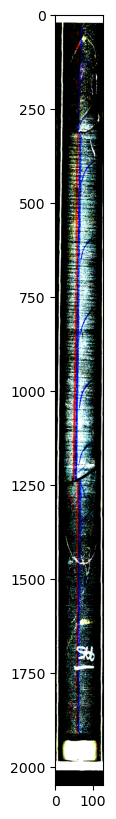

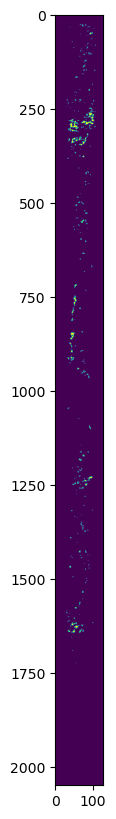

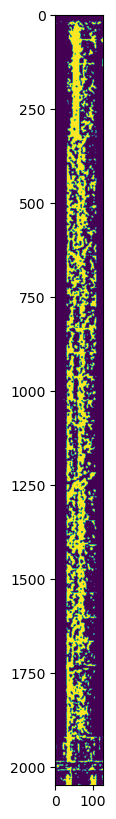

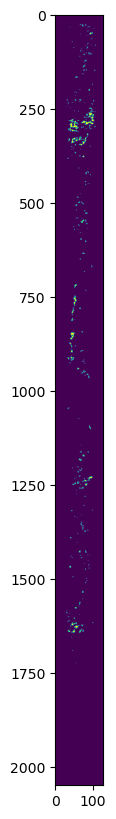

In [282]:
plot_img(np.transpose(img.cpu().detach().numpy()[0,:,:,:],[2,1,0]).astype('float'))
# plot_img(np.transpose(mask.cpu().detach().numpy()[0,:,:],[1,0]).astype('float'))
plot_img(outputs)
plot_img(outmasks)

# Dice score evaluation

In [283]:
from scipy.spatial.distance import dice
def dsc(im1,im2):
    return 1-dice(im1.flatten(),im2.flatten())

def IOU(im1,im2):
    return np.sum(im1*im2)/np.sum((im1+im2)>0)

In [284]:
dsc(outputs,outmasks)
IOU(outputs,outmasks)

0.033285642147786565

In [286]:
av_dsc = 0
# train_loader, val_loader = create_dataset(path, label_path, 'sericite',1) #Returns data loaders
train_iter = iter(train_loader)
val_iter = iter(val_loader)

for i in range(len(train_loader)):
    img, mask = next(train_iter)
    img = img.to(device)
    mask = mask.to(device)
    outputs, outmasks = infer(modelpath,img,'sericite',class_min_dict,mask)
    av_dsc += dsc(outmasks,outputs)
    
print('Average training dice score: ', av_dsc/len(train_loader))

av_dsc = 0
for i in range(len(val_loader)):
    img, mask = next(val_iter)
    img = img.to(device)
    mask = mask.to(device)
    outputs, outmasks = infer(modelpath,img,'sericite',class_min_dict,mask)
    av_dsc += dsc(outmasks,outputs)
    
print('Average val dice score: ', av_dsc/len(val_loader))
    

Average training dice score:  0.14330677273041326
Average val dice score:  0.183693271847915


# Basic visualization

In [309]:
def register_imgs(img_path, label_path,mineral_type):
    '''Registers an image with its mask and returns both'''
    im1 = cv2.imread(img_path)
    im2 = cv2.imread(label_path)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

    j2k = glymur.Jp2k(img_path)
    j2k2 = glymur.Jp2k(label_path)

    rgb_tiepoint = j2k.box[3].data['ModelTiePoint'][3:6]
    cm_tiepoint = j2k2.box[3].data['ModelTiePoint'][3:6]
    rgb_res = j2k.box[3].data['ModelPixelScale'][0]
    cm_res = rgb_res*10

    rgb_box = (rgb_tiepoint,rgb_tiepoint+[im1.shape[1]*rgb_res,-im1.shape[0]*rgb_res,0])
    cm_box = (cm_tiepoint,cm_tiepoint+[im2.shape[1]*cm_res,-im2.shape[0]*cm_res,0])


    im1 = cv2.copyMakeBorder(im1, -min(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                              max(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                              max(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                              -min(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                             cv2.BORDER_CONSTANT)
    im2 = cv2.copyMakeBorder(im2, max(int((rgb_box[0][1]-cm_box[0][1])/cm_res),0),
                              -min(int((rgb_box[1][1]-cm_box[1][1])/cm_res),0),
                              -min(int((rgb_box[0][0]-cm_box[0][0])/cm_res),0),
                              max(int((rgb_box[1][0]-cm_box[1][0])/cm_res),0),
                             cv2.BORDER_CONSTANT)

    im1 = cv2.resize(im1, (128,2048))
    im2 = cv2.resize(im2, (128,2048), interpolation=cv2.INTER_NEAREST)


    mask = create_mask(np.transpose(im2,[2,0,1]),mineral_type,class_min_dict)
                     
    return im1, mask
                     
def plot_img(img):
                
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    return

def plot_img_mask(img,mask):
    '''Overlay 1-channel mask on 3-channel image'''
    mask = np.expand_dims(mask,axis=-1)*255
    mask = np.concatenate([mask,mask,mask],axis=-1).astype('int')
    plt.figure(figsize=(10,10))
    dst = cv2.addWeighted(img,0.5,mask,0.7,0)
    plt.imshow(dst[:,:,:])
    return



In [278]:
img_list = sorted([os.path.join(path,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))])
label_list = sorted([os.path.join(label_path,f) for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path,f))])

im, mask = register_imgs(img_list[0],label_list[0],'sericite')
plot_img_mask(im,mask)

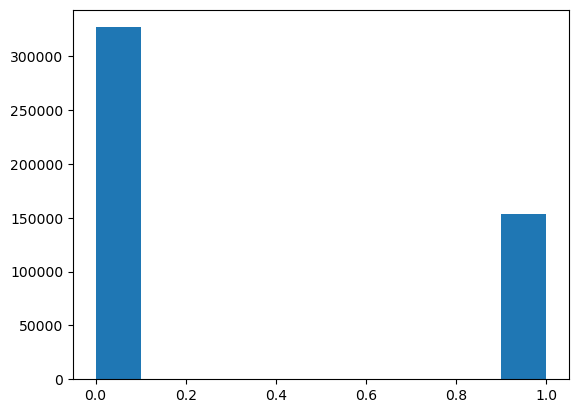

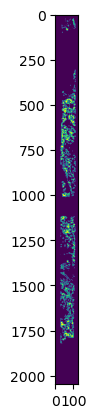

In [316]:
alt_label_path = '../img-sm-chl'
alt_label_list = sorted([os.path.join(alt_label_path,f) for f in os.listdir(alt_label_path) if os.path.isfile(os.path.join(alt_label_path,f))])

im = cv2.imread(alt_label_list[0])
plt.hist((((im-np.min(im))/(np.max(im)-np.min(im)))>0.1).astype('float').flatten())

im, mask = register_imgs(img_list[0],label_list[0],'sericite')
plt.figure()
plt.imshow(mask)